In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

D:\Anaconda\Continuum\anaconda3\envs\py36\python.exe
3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 18:50:55) [MSC v.1915 64 bit (AMD64)]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import os
# import codecs

In [421]:
target_url = ("test2.xlsx")
# target_url = ("C:/Dev/Projects/snow/data/export3.xlsx")
test = pd.read_excel(target_url)

In [422]:
test['date'] =test.Created.dt.date

In [423]:
test.head(2)

,Number,Assignment_group,Priority,State,Category,Subcategory,Severity,Closure_CI,Location,Close_code,...,Duration,Impact,Short_description,Created,new_desc,Terms,IPs,Cluster,cluster_name,date
0,INC0489304,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,Network Account Issue,Mercy Medical Center Merced (MMCM),Application,...,213,No Impact,Network Password Reset,2018-10-14 23:56:41,Network Password Reset Security Application Network Account Issue,password reset security application account,NaN,10,password,2018-10-14
1,INC0489303,DHE-Command Center,2 - High,Closed,Server,Windows,3 - Low,phx-vapp-835,Corporate Office - Phoenix 1,Resolved by Event,...,2373,Degraded for Multiple IT Customers,"'10.248.100.25': Ping packet good percentage is '0'%'. See ""Additional Info"" for timings",2018-10-14 23:52:57,"'10.248.100.25': Ping packet good percentage is '0'%'. See ""Additional Info"" for timings Server ...",ping packet percentage see additional info time server event,10.248.100.25 phx-vapp-835,5,application,2018-10-14


In [166]:
import datetime 
dates_df1 = test['date'].value_counts().sort_index()

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

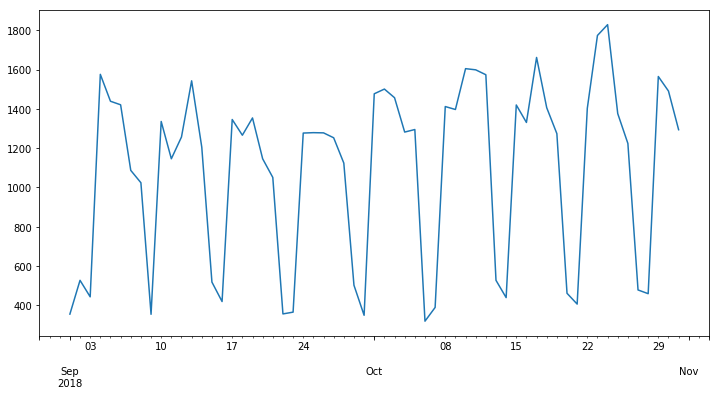

In [359]:
#Using continuous data , including weekends which have low volumes
plt.figure(figsize=(12,6))
dates_df2 = dates_df1 
#[dates_df1 > 600]              
#tried by removed count < 600 to have a better trend  but it breaks continuity
dates_df2.index = pd.to_datetime(dates_df2.index)
dates_df2.plot(x = 'Date', y = 'Counts')

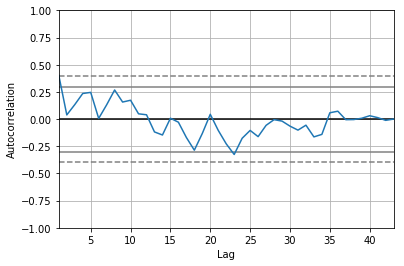

In [174]:
#autocorrelation - After removing weekends  (daily incident count <600)
#time series lag analysis for ARMA/ARIMA
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dates_df2_remwk)

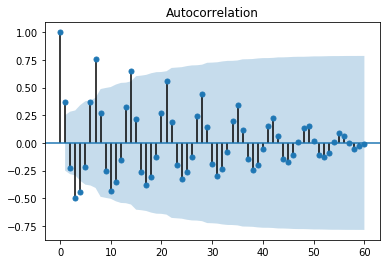

In [360]:
#autocorrelation for daily volumnes including weekends, shows lot of cyclicity, 
#inference from ACF and PACF plot still not clear
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dates_df2)
plt.show()

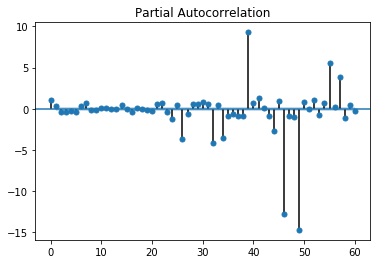

In [361]:
#partial autocorrelation for daily volumnes , # how to infer?
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dates_df2)
plt.show()

## Time Series Analysis

ARMA and ARIMA, included SARIMA for Seasonality

http://www.statsmodels.org/devel/examples/notebooks/generated/tsa_arma_0.html
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_1.html
https://www.statsmodels.org/dev/examples/index.html#stats
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

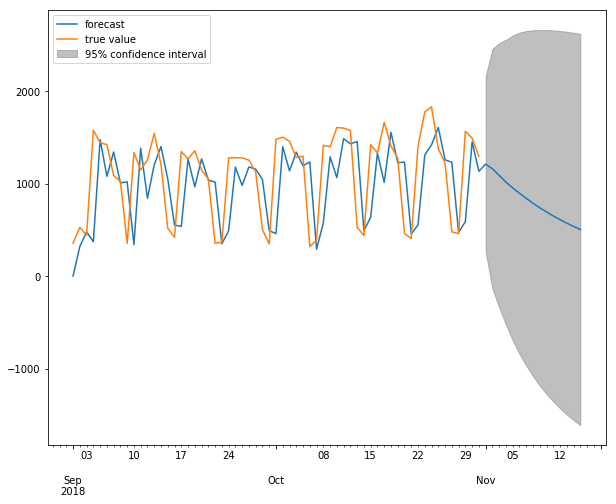

In [416]:
#ARMA forecast
import statsmodels.api as sm

arma_mod = sm.tsa.ARMA(dates_df2, order=(3,0))
arma_res = arma_mod.fit(trend='nc', disp=-1)
#print(arma_res.summary())

#Plot
fig, ax = plt.subplots(figsize=(10,8))
start_index = datetime(2018, 9, 1)
end_index = datetime(2018, 11, 15)
fig = arma_res.plot_predict(start=start_index, end=end_index, ax=ax)
legend = ax.legend(loc='upper left')
legend.get_texts()[1].set_text('true value')

In [406]:
######ARIMA

from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot
 
incident= dates_df2.copy()
# fit model
model = ARIMA(incident, order=(5,1,1))
arima_res = model.fit()
#print(model_fit.summary())


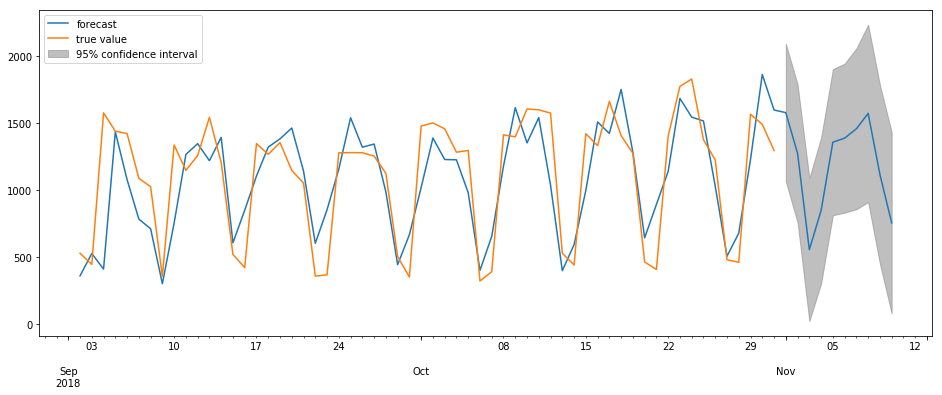

In [415]:
#ARIMA forecast
start_index = datetime(2018, 9, 1)
end_index = datetime(2018, 11, 15)
fig, ax = plt.subplots(figsize=(16,6))
fig = arima_res.plot_predict(start=1, end=70, ax=ax)

legend = ax.legend(loc='upper left')
legend.get_texts()[1].set_text('true value')

In [328]:
#Evaluate ARMA/ARIMA model parameters - GridSearch method
# we get 7,1,0 as best
from statsmodels.tsa.arima_model import ARMA


# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X,model_type,arima_order):
	# prepare training dataset
    train_size = int(len(X) * 0.66)
    #print("aaa",model_type)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
	# make predictions
    predictions = []
    for t in range(len(test)):
        
        if model_type =='ARIMA':
            model = ARIMA(history, order=arima_order)
        elif model_type =='ARMA':
            model = ARMA(history, order=arima_order)
            
        else:
            model=None
            
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        #print("cc")
        predictions.append(yhat)
        history.append(test[t])
	# calculate out of sample error
    error = mean_squared_error(test, predictions)
    #print("order,error")
    #print(arima_order,error)

    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset,model_type, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                if model_type =='ARIMA':
                    order = (p,d,q)
                elif model_type =='ARMA':
                    order = (p,q)
                try:
                    mse = evaluate_arima_model(dataset,model_type, order)
                    print(model_type +'%s MSE=%.3f' % (order,mse))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        
                except:
                    print("Exception:",order)
                    continue

    print('Best '+model_type+' %s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [2,3,5]
d_values = [0]# NOT USED for ARMA
q_values = [0,1]

evaluate_models(dates_df2.values,'ARMA', p_values, d_values, q_values)


ARMA(2, 0) MSE=39126.130
Exception: (2, 1)
ARMA(3, 0) MSE=37190.769
Exception: (3, 1)
ARMA(5, 0) MSE=41405.022
ARMA(5, 1) MSE=38240.044
Best ARMA (3, 0) MSE=37190.769


In [365]:
# evaluate parameters ARIMA
p_values = [3,5,7]
d_values = [0,1]
q_values = [0,1]

evaluate_models(dates_df2.values,'ARIMA', p_values, d_values, q_values)

ARIMA(3, 0, 0) MSE=162936.439
ARIMA(3, 0, 1) MSE=174772.098
ARIMA(3, 1, 0) MSE=261778.985
Exception: (3, 1, 1)
ARIMA(5, 0, 0) MSE=165347.235
ARIMA(5, 0, 1) MSE=159763.507


D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 1, 0) MSE=148356.910
ARIMA(5, 1, 1) MSE=89842.424
Exception: (7, 0, 0)
Exception: (7, 0, 1)


D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Exception: (7, 1, 0)
Exception: (7, 1, 1)
Best ARIMA (5, 1, 1) MSE=89842.424


In [371]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
 

# fit model
model = SARIMAX(dates_df2, order=(5,1,1),seasonal_order=(1, 0, 0, 7))
sarma_res = model.fit()
#print(model_fit.summary())

D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


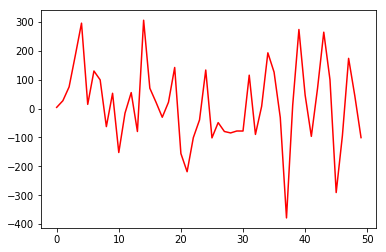

In [357]:
# Arima predictions shows differences so it has to be converted to actual prediction : TODO
arima_pred2 = arma_res.predict(start=1, end=50)
plt.plot(arima_pred2, 'r') 


plt.show()

In [382]:
start_index = datetime(2018, 9, 1)
end_index = datetime(2018, 11, 15)
sarima_pred2 = sarma_res.predict(start=start_index, end=end_index)

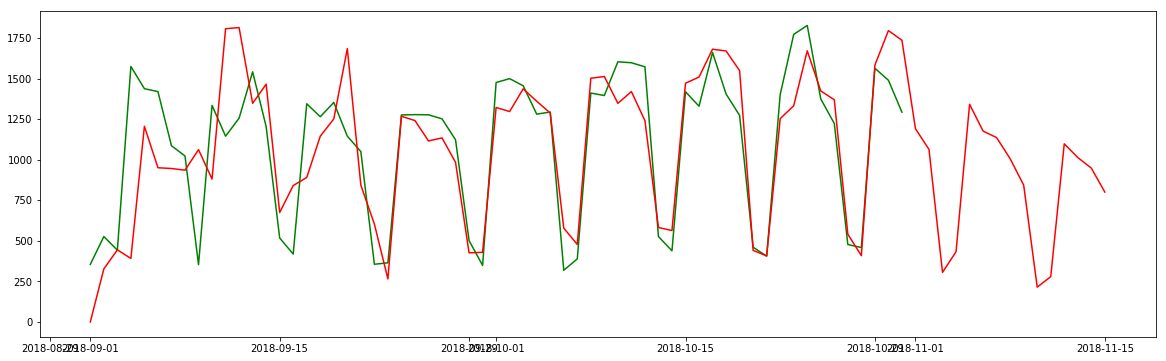

In [387]:
#Plotting true values and SARIMA predictions 
#dates_df3 = dates_df2.reset_index(drop=True)
plt.subplots(figsize=(20,6))
plt.plot(dates_df2, 'g') # plotting t, b separately 
plt.plot(sarima_pred2, 'r') 
plt.show()

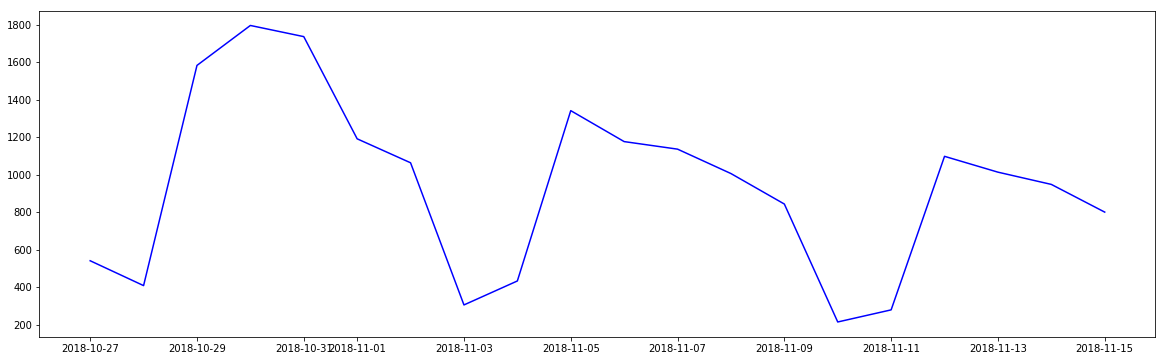

In [386]:
#SARIMA plot for out of sample dates (Nov 2018) 
plt.subplots(figsize=(20,6))
plt.plot(sarima_pred2[-20:], 'b') # plotting t, b separately 

plt.show()

### Facebook prophet

In [447]:
df_fb = pd.DataFrame()
df_fb['ds'] = dates_df2.index
df_fb['y'] = dates_df2.values
df_fb.head()

,ds,y
0,2018-09-01,355
1,2018-09-02,527
2,2018-09-03,443
3,2018-09-04,1576
4,2018-09-05,1439


In [448]:
#Install Prophet from facebook
from fbprophet import Prophet

model = Prophet() 
model.fit(df_fb) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [454]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
86,2018-11-26,1311.561333,1280.164874,1748.891748,1310.393785,1312.849470,196.673329,196.673329,196.673329,196.673329,196.673329,196.673329,0.0,0.0,0.0,1508.234662
87,2018-11-27,1315.331939,1389.784897,1876.178578,1314.073302,1316.699184,313.058949,313.058949,313.058949,313.058949,313.058949,313.058949,0.0,0.0,0.0,1628.390887
88,2018-11-28,1319.102544,1441.701341,1919.503620,1317.783153,1320.556613,355.383015,355.383015,355.383015,355.383015,355.383015,355.383015,0.0,0.0,0.0,1674.485559
89,2018-11-29,1322.873149,1362.602084,1832.481746,1321.477716,1324.406594,279.169265,279.169265,279.169265,279.169265,279.169265,279.169265,0.0,0.0,0.0,1602.042415
90,2018-11-30,1326.643755,1217.287689,1678.559975,1325.180961,1328.252994,126.781860,126.781860,126.781860,126.781860,126.781860,126.781860,0.0,0.0,0.0,1453.425615


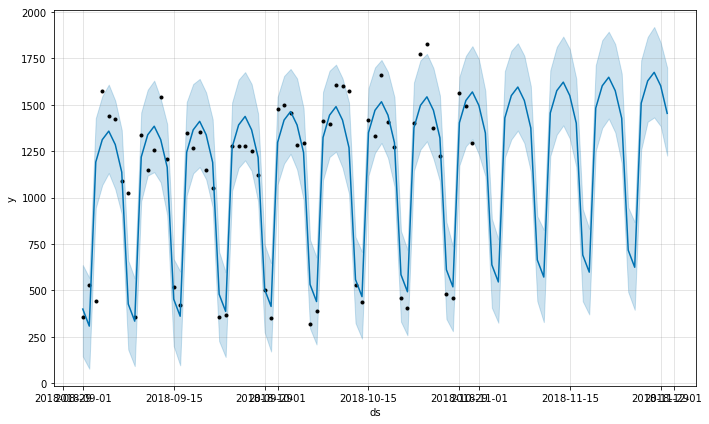

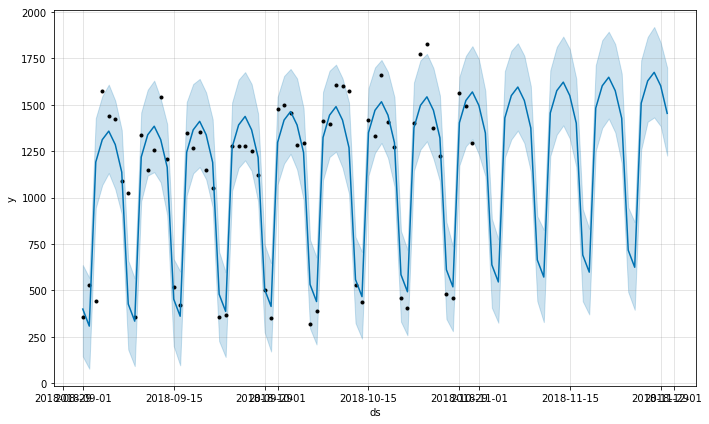

In [452]:
model.plot(forecast)

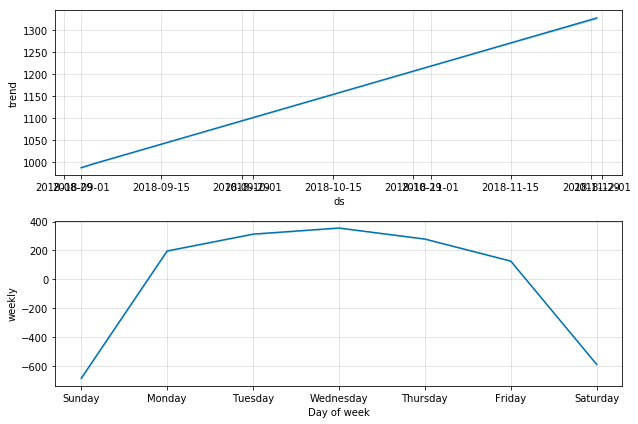

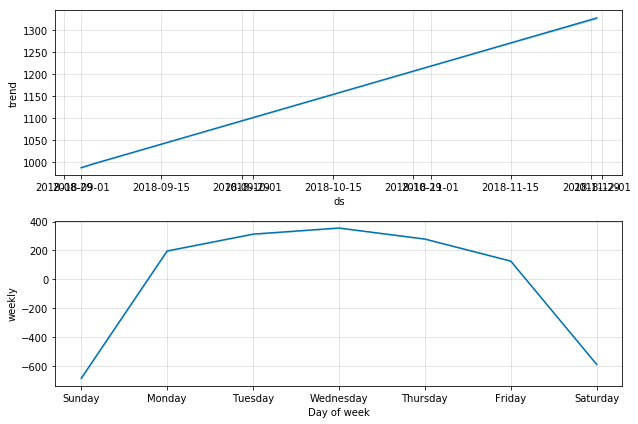

In [453]:
model.plot_components(forecast)

Options for multivariate data -  

   1. run above models for each category/label - 
   2. goto new model like VAR/VARMA --Vector Autoregression Moving-Average (VARMA)

Option 1
we need data in this format

Date index ----  Category 1 Count  --- Category 2 Count ----Category 3 Count

run this data in loop through the above univariate models


In [439]:
df1=test[['Category', 'date','Number']]
#.groupby(['Category', 'date']).agg(['count'])

In [440]:
df2=DataFrame({'count' : df1.groupby( [ 'Category', 'date'] ).size()}).reset_index()

In [445]:
s1 = pd.Series(df2[df2.Category=='Application']['count'].values, index=df2[df2.Category=='Application']['date'])  #[df2.Category=='Application']
s1.head()

date
2018-09-01     83
2018-09-02     88
2018-09-03     92
2018-09-04    359
2018-09-05    380
dtype: int64

In [442]:
df3= df2[df2.Category=='Application']
df3.head()

,Category,date,count
0,Application,2018-09-01,83
1,Application,2018-09-02,88
2,Application,2018-09-03,92
3,Application,2018-09-04,359
4,Application,2018-09-05,380




#### multivariate time series - Vector Autoregression Moving-Average (VARMA)

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html



In [419]:
# VARMA example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = []
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VARMAX(data, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

[[0.34726357 0.87751947]]


D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [231]:
from pandas import datetime
start_index = datetime(2018, 11, 1)
end_index = datetime(2018, 11, 15)
forecast = model_fit.predict(start=15, end=17)
print(forecast)

[309.11120923  79.51554866  36.14511902]


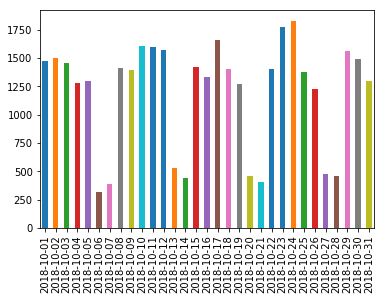

In [159]:
#top_dates_df2 = top_dates_df1
dates_df1.plot.bar(x = 'Date', y = 'Counts')

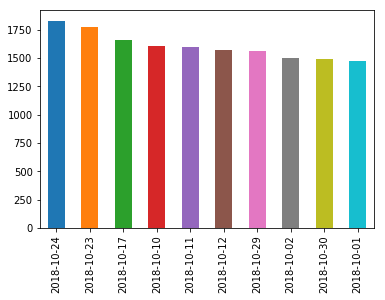

In [154]:
top_dates_df1[:10].plot.bar(x = 'Date', y = 'Counts')

In [92]:
temp4 = test[['Priority',  'Category', 'Close_code', 'Impact','Cluster' ]]

labels1,levels1 = pd.factorize(temp.Priority)
labels2,levels2 = pd.factorize(temp.Category)
labels3,levels3 = pd.factorize(temp.Close_code)
labels4,levels4 = pd.factorize(temp.Impact)
temp4['Priority1'] =  labels1
temp4['Category2'] =  labels2
temp4['Close_code3'] =  labels3
temp4['Impact4'] =  labels4

from sklearn.ensemble import RandomForestClassifier

# Isolate Data, class labels and column values
X = temp4[['Priority1','Category2','Close_code3','Impact4']]
Y = temp4.Cluster
names = ['Priority1','Category2','Close_code3','Impact4']

# Build the model
rfc = RandomForestClassifier()

# Fit the model
rfc.fit(X, Y)



D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [93]:
# Print the results
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.4301, 'Close_code3'), (0.364, 'Category2'), (0.1488, 'Impact4'), (0.0571, 'Priority1')]


## Old Code

In [8]:
# identify the cols needed
cols = ['Number', 'Assignment_group', 'Priority', 'State', 'Category',
       'Subcategory', 'Severity', 'Closure_CI', 'Location', 'Close_code',
       'Configuration_item',  'Contact_type',
       'Duration', 'Impact', 'Short_description', 'Created']
df = df[cols]

In [9]:
# copy the dataframe to a new dataframe before any row deletes
test = df.copy()

In [10]:
test['new_desc'] = test['Short_description']+ ' ' + test['Category']+' ' + test['Close_code']+ ' ' + test['Closure_CI']

In [11]:
# check for duplicate data
test[test['new_desc'].duplicated(keep = 'first')].sort_values('new_desc').head(5)

,Number,Assignment_group,Priority,State,Category,Subcategory,Severity,Closure_CI,Location,Close_code,Configuration_item,Contact_type,Duration,Impact,Short_description,Created,new_desc
38013,INC0503842,DH-ClinApps HIM,3 - Moderate,Closed,Application,Revenue Cycle,3 - Low,Cerner CPDI Kofax,Dignity Health Medical Group-Sierra Nevada-Gra...,Application,CAREB Cerner Millennium HIM,Phone,27464,Degraded for One IT Customer,Cerner CDI Work Queue Monitor - Not Receiving...,2018-10-23 08:52:42,Cerner CDI Work Queue Monitor - Not Receiving...
37900,INC0503959,DH-ClinApps HIM,4 - Low,Closed,Application,NaN,3 - Low,Cerner CPDI Kofax,Methodist Hospital of Sacramento (METH),Application,Kofax Capture v11,Phone,7047,No Impact,Cerner CDI Work Queue Monitor - Not Receiving...,2018-10-23 09:15:30,Cerner CDI Work Queue Monitor - Not Receiving...
37882,INC0503977,DH-ClinApps HIM,4 - Low,Closed,Application,NaN,3 - Low,Cerner CPDI Kofax,Woodland Healthcare Davis,Application,Cerner Millennium Provider Doc 2015.01.19,Self-service,6784,Down for One IT Customer,Cerner CDI Work Queue Monitor - Not Receiving...,2018-10-23 09:19:22,Cerner CDI Work Queue Monitor - Not Receiving...
33805,INC0508184,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,DUO Security,St Joseph's Medical Center Stockton (SJMC),Access,DUO Security,Phone,343,No Impact,DUO Mobile/to be enrolled/guided to enroll fr...,2018-10-24 20:38:48,DUO Mobile/to be enrolled/guided to enroll fr...
34134,INC0507855,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,DUO Security,St Rose Dominican Hospital - Siena (SRDH-S),Access,DUO Security,Phone,284,No Impact,DUO Mobile/to be enrolled/guided to enroll fr...,2018-10-24 18:19:06,DUO Mobile/to be enrolled/guided to enroll fr...


In [12]:
# remove duplicates, we will still retain 1 row for analysis
test = test.drop_duplicates('new_desc', keep = 'first')
print('Shape of the modified dataframe ', test.shape)

Shape of the modified dataframe  (66722, 17)


In [24]:
#Filter out some categories with instances < 50 for now , remove this filter in future
# test = incs.groupby("Category").filter(lambda x: len(x) > 50)
# test = incs.reset_index(drop = True)
test.Category.value_counts()

Application          15451
End User Services    14865
Security             11313
Network               6114
Server                5809
HelpDesk              2817
Telecom               1267
EAI Interface         1184
Human Resources       1024
EAI Component          295
Storage                116
Facility                99
Database                 2
Name: Category, dtype: int64

In [13]:
pd.options.display.max_colwidth = 100

In [14]:
# remove any accent from letters
def unidecode_text(text):
    try:
        text = unidecode.unidecode(text)
    except:
        pass
    return text

for col in ['Location', 'Short_description']:
    test[col] = test.apply(lambda row: unidecode_text(row[col]), axis = 1)

In [15]:
# copy location to another data frame and remove duplicates
locations = test['Location']
locations = locations.drop_duplicates(keep = 'first')
locations.head()

0             Mercy Medical Center Merced (MMCM)
1                   Corporate Office - Phoenix 1
3    Community Hospital of San Bernardino (CHSB)
5                        Sequoia Health Services
8                   Mercy General Hospital (MGH)
Name: Location, dtype: object

In [16]:
# stop words for location

# nltk text preprocessing
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import contractions

stop = stopwords.words('english')
lemmer = WordNetLemmatizer()

# add punctuations to the stop words
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop.extend(punc)

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def get_locations(text):

    # lower case
    text = text.lower()
#     text = text.str.lower()

    # replace '\', '/', '|', '-' with spaces, thes are usually entered to separate words
    # word tokenize doesn't tokenize on these
    text = re.sub(r'[.=\\/\|-]',' ', text)

    # replace contractions
    text = ' '.join(contractions.fix(word) for word in text.split())
#     text = text.apply(lambda x: ' '.join(contractions.fix(word) for word in x.split()))
    
    # tokenize text and remove puncutation, strip would remove from word begining or end
    text = [word.strip(string.punctuation) for word in word_tokenize(text)]
#     text = text.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in word_tokenize(x)))
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
#     text = text.apply(lambda x: ' '.join(word for word in word_tokenize(x) if not any(c.isdigit() for c in word)))

    # remove small tokens
    text = [word for word in text if len(word) > 1]
#     text = text.apply(lambda x: ' '.join(word for word in word_tokenize(x) if len(word) > 1))
    
    # remove stop words
    text = [word for word in text if word not in set(stop)]
#     text = text.apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in set(stop)))
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [lemmer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
#     text = text.apply(lambda x: ' '.join(lemmer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tag(x)))
    
    text = ' '.join(text)
    
    return(text)
    
# locations_cleaned = get_locations(locations.astype(str))
locations_cleaned = locations.apply(lambda x: get_locations(str(x)))

In [17]:
locations_cleaned.head()

0          mercy medical center merced mmcm
1                  corporate office phoenix
3    community hospital san bernardino chsb
5                    sequoia health service
8                mercy general hospital mgh
Name: Location, dtype: object

In [19]:
# use the countvectorizer to convert to a list of words
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit_transform(locations_cleaned.values)

stop_locations = vectorizer.get_feature_names()
len(stop_locations)

504

In [20]:
stop_locations[100:110]

['de',
 'deactivate',
 'department',
 'detention',
 'development',
 'dhmf',
 'dhmg',
 'dhmgn',
 'dhmso',
 'diabetes']

In [22]:
# extend stop words
# words like issue, problem, resolve, fix - do not add more sense to the description and are common
new_stopwords = ['chw','edu','phx','vapp', 'issue', 'issues', 'problem', 'problems', 'loc','do','es',
                 'resolve', 'resolved', 'fix', 'fixed']

stop.extend(new_stopwords)

# add the locations to the stop words
stop.extend(stop_locations)


def pre_process(text):

    # lower case
    text = str(text).lower()

    # replace '\', '/', '|', '-' with spaces, thes are usually entered to separate words
    # word tokenize doesn't tokenize on these
    text = re.sub(r'[.=\\/\|-]',' ', text)

    # replace contractions
    text = ' '.join([contractions.fix(word) for word in text.split()])

    # "'d": changes to " would", 'disk changes to wouldisk - unwanted contraction
    # replace wouldisk with disk
    text = text.replace('wouldisk', 'disk')  # replace with disk    

    # 'not able' is a common way to report issue, replace 'not able' with 'unable'
    # also not gets removed as part of stop words
    text = text.replace('not able', 'unable')
    text = text.replace('user id', 'user')
    text = text.replace('username', 'user')
    
    # replace ms4 to medseries
    text = text.replace('ms4', 'medseries')
    
    # there are lot of places in the description where II (2 caps I) has been used as separator
    # this gets converted to small letter (ii) with high occurance, drop these letters
    text = text.replace(' ii ', ' ')  # replace with spaces
        
    # tokenize text and remove puncutation, strip would remove from word begining or end
    text = [word.strip(string.punctuation) for word in word_tokenize(text)]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

    # remove small tokens
    text = [word for word in text if len(word) > 2]
    
    # remove stop words
    text = [word for word in text if word not in set(stop)]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [lemmer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # some verbs probably get tagged as noun and are not lemmatized
    text = [lemmer.lemmatize(word, pos = 'v') for word in text]
    
    text = ' '.join(text)    
  
    return (text)
    
# cleaned_short_desc = pre_process(incs['Short_description'].astype(str))
%time cleaned_short_desc = test['new_desc'].apply(lambda x: pre_process(x))

Wall time: 1min 57s


In [23]:
cleaned_short_desc[0:20]

0                                                             password reset security application account
1                                            ping packet percentage see additional info time server event
2                                        vprt cpu utilization threshold set utilization server event vprt
3                    cerner unable access correct view application application cerner millennium firstnet
4                                                  cpu utilization threshold set utilization server event
5     unable login user acc lock unlock acc hduv do password reset do able login change password secur...
6                                           active job complete exit status server application snhc misys
7                                 vctx utilization threshold set disk file percent full server event vctx
8              medseries unable login user svillaraza dev application password reset medseries production
9          desktop unable save word document f

In [57]:
# count of cells with no terms
print(cleaned_short_desc.apply(lambda x: len(x) < 10).sum())

3


In [30]:
def get_ips(text):
    
    # lower case
    text = text.str.lower()
    
    # capture the IPs    
    ip_pattern = re.compile(r'((-?)([A-Za-z0-9]{1,}[-.]{1,1}){2,6}([A-Za-z0-9]*))')  
    ip = text.apply(lambda x: ' '.join(word for word in re.split('[\': (),]', str(x)) if ip_pattern.match(word)))
    
    return ip

ips = get_ips(test['new_desc'])

In [31]:
ips[0:20]

0                                      
1            10.248.100.25 phx-vapp-835
2     phx-vprt-002.chw.edu phx-vprt-002
3                            2015.10.19
4     bmh-vapp-002.chw.edu bmh-vapp-002
5                                      
6                         snhc-misys-01
7     phx-vctx-114.chw.edu phx-vctx-114
8                                      
9              10.217.114.136//assisted
10                                     
11      phx-app-030.chw.edu phx-app-030
12                                     
13      phx-app-030.chw.edu phx-app-030
14                                     
16                                     
17                                     
18    bmh-vapp-002.chw.edu bmh-vapp-002
19    phx-vprt-002.chw.edu phx-vprt-002
20                                     
Name: new_desc, dtype: object

In [32]:
# add the processed text and extracted ips to dataframe
test['Terms'] = cleaned_short_desc
test['IPs'] = ips

In [38]:
# drop the rows where 'Terms' column is spaces
# test = test[test['Terms'] != '']

In [39]:
# this cell is just for testing regex, etc
# import re

# print(re.split('[:\' ]', '\'phx-vapp-689.chw.edu\': Utilization is \'85.2\'. Threshold is set to \'Disk/File System/{C}/percent full >= 85\''))

# ip_pattern = re.compile(r'((-?)([A-Za-z0-9]{1,}[-.]{1,1}){2,6}([A-Za-z0-9]*))') 

# print(ip_pattern.match('phx-vapp-238.chw.edu'))
# print(ip_pattern.match('CPU Utilization is '))
# print(ip_pattern.match('85.2'))
# print(ip_pattern.match('10.250.243.2'))
# print(ip_pattern.match('-10.248.84.17'))
# print(ip_pattern.match('192.168.2.85)'))
# print(ip_pattern.match('10.1.5.100'))


# test = pd.DataFrame({'strings': ['...', 'a(b$c']})
# test.strings.str.replace('[^a-zA-Z ]', ' ')

# print('This is a test in spite.'.split())
# print(lemmer.lemmatize('physicians', pos='v'))
# text = "SMMC-////\\\\_||||==SF sdcchmc_lis.chw.edu"
# text = re.sub(r'[.=\\/\|-]',' ', text)
# print(text)

# alpha = re.compile(r'([A-Za-z/\-]*$)')

# dk = pd.DataFrame({'sentences': ['This is a very MS4 ABCD901 \'abc.xyz.109.01\' good site. I will recommend it to others.', 
#                                  'Can you please give me a call at 9983938428. have issues with the listings.', 
#                                  'WOW / Workstation on Wheels || WOW / Workstation on Wheels Issue',
#                                  '\'phx-vapp-689.chw.edu\': Utilization is \'85.2\'. Threshold is set to \'Disk/File System/{C}/percent full >= 85',
#                                  'Clairvia/not able to login//password reset hduv done jmoyrong/issue resolved',
#                                  'God is Great/I won a lottery.',
#                                  'CIM_2_BAYDSC19_MSFCHGX:MSF19CHGX:MedSeries 4:TIER-2 P05:DESTINATION_REALTIME:No host at ipAddress -10.248.84.17, listening on port -21529. :Charges - Multiple t',
#                                  'Account Lock ||  Not able to login || user id-adeperalta001',
#                                  'good work! keep it up, couldn\'t able to login, couldn\'t connect']})

# dk['tokenized_sents']  = dk['sentences'].apply(lambda x: ' '.join(word for word in re.split('[\': (),]', x) if ip_pattern.match(word)))



# dk['tokenized_sents'] = dk['sentences'].apply(lambda x: ' '.join(word.lower() for word in x.split()))  # lower case
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join(contractions.fix(word) for word in x.split()))  # replace contractions

# dk['tokenized_sents'] = dk['tokenized_sents'].str.replace('not able', 'unable')
# dk['tokenized_sents'] = dk['tokenized_sents'].str.replace('[\/-]', ' ')  # replace them with spaces

# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if alpha.match(word)))
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join([lemmer.lemmatize(word, pos='v') for word in word_tokenize(x)]))       #lemma
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in set(stop)]))   #stop

# print(dk['tokenized_sents'])

In [33]:
# view the terms column just before feature extraction
test['Terms'][1470:1490]

1800                                         vii cpu utilization threshold set utilization server event vii
1801                                                 account unable login team security application account
1811                                                               round end user service hardware hardware
1813                                  nfuse unable launch script application end user service access citrix
1814                                                               round end user service hardware hardware
1815    visual cactus want dea information get update user kevin kuhn user dep clinical info application...
1817                                                                        phone phone telecom event phone
1819          journey unable access take enable manage add ins reset browser human resource security course
1820                                 team unable login user browser old version application access api team
1822                cerner u

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_features=10000, max_df=0.8, min_df=0.0005,                                  
#                                   use_idf=True, tokenizer=word_tokenize, ngram_range=(1,3))

vectorizer = TfidfVectorizer(max_features = 5000,  min_df=0.0005  ,                           
                                  use_idf = True, tokenizer = word_tokenize, ngram_range = (1,1))

%time X = vectorizer.fit_transform(test['Terms'].values)

print(X.shape)

Wall time: 7.81 s
(66722, 969)


In [36]:
features = vectorizer.get_feature_names()
freq = sum(X).toarray()[0]
test_features = pd.DataFrame(freq, index = features, columns = ['frequency'])

# sort the terms in descending order of frequency
test_features.sort_values(by = ['frequency'], inplace = True, ascending = False)

In [37]:
# print the top 50 occurances
print(test_features[0:50])

               frequency
application  5082.016388
user         4504.105691
account      4309.531169
security     3142.201299
unable       3061.599663
end          3053.938461
service      2942.821366
login        2664.083685
password     2390.996942
desktop      2355.935663
reset        2089.820966
hardware     2074.283498
access       2034.493397
mdf          1995.294891
lock         1872.430532
cerner       1691.605171
server       1625.444267
medseries    1625.094674
unlock       1606.230417
main         1566.003216
event        1559.370996
printer      1406.031513
device       1274.049689
need         1228.496137
laptop       1130.527063
dev          1111.858098
error        1103.278650
duo          1073.915808
helpdesk     1066.189539
interface     954.505370
software      905.262066
status        903.673423
computer      892.263385
power         849.997039
outage        840.193731
utilization   833.444941
encryption    822.309940
phone         790.901417
set           762.780698


In [44]:
# print the last 20 occurances - terms with low frequency
# how low is the frequency? do we have correct number of features
print(test_features.tail(20))

            frequency
gmhmed       0.681759
ipa          0.671874
junk         0.664677
sell         0.658289
synonym      0.655643
ri           0.654936
woodrd       0.646431
nvnlv        0.642154
nvbd         0.641287
rlenz        0.639648
sbmcclin     0.634918
speechq      0.630863
ssrnet       0.607296
hambleton    0.603334
reaso        0.580431
smartwrite   0.573038
sakuru       0.573038
httpd        0.554465
httpserver   0.528130
sophia       0.521252


In [45]:
print(len(features))

969


In [46]:
# using elbow method to find optimum number of clusters - start with 30 clusters

# from sklearn.cluster import KMeans
# wcss = []

# for i in range(30, 51):
#     km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 1)
#     km.fit(X)
#     wcss.append(km.inertia_)
 
# optimal_clusters = np.argmin(wcss) + 2 # As argmin return the index of minimum loss.

# plt.plot(range(30, 51), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.show()

# print ("The optimal number of clusters obtained is - ", optimal_clusters)
# print ("The loss for optimal cluster is - ", min(wcss))

In [46]:
num_clusters = 40

# KMeans
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
# %time y = kmeans.fit_predict(X)
# %time kmeans.fit(X)

# Mini Batch KMeans
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters = num_clusters, init = 'k-means++', 
                         max_iter = 300, n_init = 3, random_state = 1)
%time kmeans.fit(X)

# clusters = kmeans.labels_.tolist()

Wall time: 659 ms


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=40,
        n_init=3, random_state=1, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [47]:
# check the number of rows in data frame and the labels
print(len(kmeans.labels_))
print(test.shape)

66722
(66722, 19)


In [48]:
# copy the kmeans.labels_ as Cluster column
test['Cluster'] = kmeans.labels_

In [49]:
# print terms to cluster mapping
print(test.loc[:10,['Terms', 'Cluster']])

                                                                                                  Terms  \
0                                                           password reset security application account   
1                                          ping packet percentage see additional info time server event   
2                                      vprt cpu utilization threshold set utilization server event vprt   
3                  cerner unable access correct view application application cerner millennium firstnet   
4                                                cpu utilization threshold set utilization server event   
5   unable login user acc lock unlock acc hduv do password reset do able login change password secur...   
6                                         active job complete exit status server application snhc misys   
7                               vctx utilization threshold set disk file percent full server event vctx   
8            medseries unable login u

In [51]:
# Save cluster in pickle file for future use
# import pickle

# pickle.dump(km, open('pkl/km_1.pkl', 'wb'))

In [50]:
# order_centroids = kmeans.cluster_centers_.argsort()[:,-1:-51:-1]
# for num, centroid in enumerate(order_centroids):
#     print(str(num) + ' : ' + ', '.join(features[word] for word in centroid))
    
# Create mapping of ngram features into clusters, 
# save into terms map object with key as cluster name (first feature in each cluster - with 2 words)
# terms = top 50 ngram features

order_centroids = kmeans.cluster_centers_.argsort()[:, :51:-1]

terms_map = pd.DataFrame(index = np.arange(0, num_clusters), columns = ['features','key'])    
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    #terms_map['key'] = i
    list = [] 
    for ind in order_centroids[i, :50]:
        print(' %s' % features[ind], end=',')
        list.append(features[ind])
    for ind2 in order_centroids[i, :1]:
        terms_map.key.loc[i] = features[ind2]

    str = ', '.join(list) 
    terms_map.features.loc[i] = str
    print()
print(terms_map.shape)

Cluster 0: apache, outcome, password, reset, application, login, do, hduv, unable, user, icu, able, pass, access, uid, change, account, unlock, name, security, vendor, need, acc, interface, temporary, give, cerner, device, require, error, lock, customer, show, dev, share, hold, information, cross, pas, patient, devid, userid, work, plan, launch, help, helpdesk, dept, type, logon,
Cluster 1: do, password, login, reset, hduv, able, account, security, unable, user, application, invision, hold, clairvia, customer, change, yes, pass, acc, medseries, rco, prod, enup, allscripts, access, formfast, buddy, logon, joe, incorrect, gecb, unlock, lock, temporary, sac, cerner, production, ps, give, sm, pas, enable, hdou, profile, sms, call, share, need, already, uid,
Cluster 2: account, lock, unlock, security, login, user, unable, acc, able, userid, customer, access, application, uid, enable, allscripts, yes, hold, name, enup, activate, do, clairvia, need, intruder, gecb, already, get, call, inquiry

Cluster 31: mdf, main, controller, associate, port, outage, status, syslog, critical, maintenance, master, dsch, ciscolwappmobilityanchordatapathdown, mcm, guestha, power, emt, tower, mfh, nst, ciscolwappmobilityanchorcontrolpathdown, module, hardware, disappear, application, bronzestar, non, mtsjh, rorc, reboot, firewall, entsensorthresholdnotification, guest, homehealth, rehab, mob, supply, device, vsmc, bouldercr, srdhsm, verdugo, roc, mdm, instruction, fex, fontanamob, att, mic, eigrp,
Cluster 32: medseries, production, application, job, access, unable, reset, login, password, user, southern, error, bay, account, unlock, lock, communication, enable, dev, number, print, device, server, security, report, adt, need, able, launch, occur, domain, human, maintenance, lkwait, remove, impact, icon, disable, do, printer, reason, name, devid, take, change, release, inquiry, uid, session, reflection,
Cluster 33: axway, mailgate, application, account, login, com, email, unlock, unable, passwor

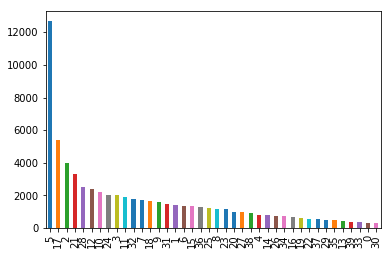

In [51]:
# analyze the clusters
top_clusters = test['Cluster'].value_counts()
top_clusters.plot.bar(x = 'Cluster', y = 'Counts')

In [59]:
test['Cluster'].value_counts()

5     12698
17     5386
2      3996
21     3288
28     2523
12     2371
10     2215
24     2027
3      2022
11     1899
32     1791
7      1700
18     1659
9      1619
31     1479
1      1397
6      1356
15     1355
36     1274
25     1228
8      1171
23     1147
20      997
27      959
38      899
4       801
14      778
26      763
34      761
16      661
19      645
22      557
37      532
29      498
35      480
13      435
39      375
33      348
0       334
30      298
Name: Cluster, dtype: int64

In [53]:
# there is high volume for cluster 1, look at few to investigate
print(test[test.Cluster == 5])['new_desc'].head()

           Number                   Assignment_group      Priority      State  \
1      INC0489303                 DHE-Command Center      2 - High     Closed   
14     INC0489290      DH-Enterprise IT Service Cntr       4 - Low     Closed   
21     INC0489283                        DHE-NS-Data  3 - Moderate     Closed   
22     INC0489282   DHE-Security and Threat Response       4 - Low     Closed   
23     INC0489281      DH-Enterprise IT Service Cntr       4 - Low     Closed   
24     INC0489280           DHE-RCM-AppOpSupport-MS4  3 - Moderate     Closed   
42     INC0489262                       DHE-SecAdmin  3 - Moderate     Closed   
70     INC0489234                 DHE-Command Center  3 - Moderate     Closed   
80     INC0489224                  DH-NC-EUS Sac MGH       4 - Low     Closed   
87     INC0489217      DHE-Integration Svs MFT Admin  3 - Moderate     Closed   
96     INC0489208                        DHE-NS-Data  3 - Moderate     Closed   
97     INC0489207           

TypeError: 'NoneType' object is not subscriptable

In [58]:
terms_map.to_csv('terms_map05.csv')


In [60]:
terms2=pd.read_csv('terms_map05.csv')
dict2 = terms2.key.to_dict()

In [63]:
#test['cluster'] = kmeans.labels_
#dataframe map integer 'cluster' into text label 'cluster_name' using dict mapping (0->login)
test['cluster_name'] = test['Cluster'].map(dict2)

test.head()

,Number,Assignment_group,Priority,State,Category,Subcategory,Severity,Closure_CI,Location,Close_code,...,Contact_type,Duration,Impact,Short_description,Created,new_desc,Terms,IPs,Cluster,cluster_name
0,INC0489304,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,Network Account Issue,Mercy Medical Center Merced (MMCM),Application,...,Phone,213,No Impact,Network Password Reset,2018-10-14 23:56:41,Network Password Reset Security Application Network Account Issue,password reset security application account,,10,password
1,INC0489303,DHE-Command Center,2 - High,Closed,Server,Windows,3 - Low,phx-vapp-835,Corporate Office - Phoenix 1,Resolved by Event,...,Event,2373,Degraded for Multiple IT Customers,"'10.248.100.25': Ping packet good percentage is '0'%'. See ""Additional Info"" for timings",2018-10-14 23:52:57,"'10.248.100.25': Ping packet good percentage is '0'%'. See ""Additional Info"" for timings Server ...",ping packet percentage see additional info time server event,10.248.100.25 phx-vapp-835,5,application
2,INC0489302,DHE-Command Center,3 - Moderate,Closed,Server,Windows,3 - Low,phx-vprt-002,Corporate Office - Phoenix 1,Resolved by Event,...,Event,592,Degraded for Multiple IT Customers,'phx-vprt-002.chw.edu':CPU Utilization is '100'. Threshold is set to 'utilization >= 95',2018-10-14 23:50:06,'phx-vprt-002.chw.edu':CPU Utilization is '100'. Threshold is set to 'utilization >= 95' Server ...,vprt cpu utilization threshold set utilization server event vprt,phx-vprt-002.chw.edu phx-vprt-002,12,utilization
3,INC0489301,DH-Enterprise IT Service Cntr,4 - Low,Closed,Application,NaN,3 - Low,Cerner Millennium FirstNet 2015.10.19,Community Hospital of San Bernardino (CHSB),Application,...,Phone,386,No Impact,cerner||Unable to access the correct view||,2018-10-14 23:37:13,cerner||Unable to access the correct view|| Application Application Cerner Millennium FirstNet 2...,cerner unable access correct view application application cerner millennium firstnet,2015.10.19,21,cerner
4,INC0489300,DHE-Command Center,3 - Moderate,Closed,Server,Windows,3 - Low,bmh-vapp-002,Corporate Office - Phoenix 1,Resolved by Event,...,Event,597,Degraded for Multiple IT Customers,'bmh-vapp-002.chw.edu':CPU Utilization is '95'. Threshold is set to 'utilization >= 95',2018-10-14 23:35:30,'bmh-vapp-002.chw.edu':CPU Utilization is '95'. Threshold is set to 'utilization >= 95' Server R...,cpu utilization threshold set utilization server event,bmh-vapp-002.chw.edu bmh-vapp-002,12,utilization


In [65]:
test.shape

(66722, 21)

In [108]:
freq = pd.Series(' '.join(test['Terms']).split()).value_counts()
freq2 = freq[freq==1]

In [109]:
freq2.shape

(10650,)

In [112]:
freq3 = freq2.index.tolist()

In [114]:

test['Terms2'] = test['Terms'].apply(lambda x: " ".join(x for x in x.split() if x not in freq3))
test['Terms2'].head()

KeyboardInterrupt: 

In [118]:
#temp['Terms']

In [66]:
temp=test.sample(frac=0.001).reset_index(drop=True)
temp.shape

(67, 21)

In [116]:
from gensim.models import Word2Vec

D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
model = Word2Vec(temp['Terms'], min_count=1)

In [68]:
temp['period'] = temp.Created.dt.to_period('H')

In [75]:
temp[['Created']].head()

,Created
period,
2018-09-05 16:00,2018-09-05 16:20:34
2018-09-25 17:00,2018-09-25 17:02:48
2018-10-03 15:00,2018-10-03 15:53:59
2018-09-13 16:00,2018-09-13 16:31:21
2018-09-25 07:00,2018-09-25 07:35:09


In [73]:
temp.set_index('period', inplace=True)

In [81]:
grouped = temp.groupby(pd.TimeGrouper(freq='D')).size()
#grouped.Category.value_counts()

D:\Anaconda\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


In [122]:
temp2 = test[['Priority',  'Category', 'Close_code', 'Impact','Cluster' ]]
temp2.head(2)

,Priority,Category,Close_code,Impact,Cluster
period,,,,,
2018-09-05 16:00,4 - Low,Application,Account Unlock,No Impact,16
2018-09-25 17:00,4 - Low,Application,Application,No Impact,5


In [121]:
temp3.head(2)

,Cluster,Priority_3 - Moderate,Priority_4 - Low,Category_Application,Category_EAI Component,Category_EAI Interface,Category_End User Services,Category_HelpDesk,Category_Human Resources,Category_Network,...,Close_code_Network,Close_code_Password Reset,Close_code_Resolved by Event,Close_code_Security,Close_code_Storage,Close_code_Utility - Software,Impact_Degraded for Multiple IT Customers,Impact_Degraded for One IT Customer,Impact_Down for One IT Customer,Impact_No Impact
period,,,,,,,,,,,,,,,,,,,,,
2018-09-05 16:00,16,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2018-09-25 17:00,5,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [126]:
temp4.tail(2)

,Priority,Category,Close_code,Impact,Cluster,Priority1,Category2,Close_code3,Impact4
period,,,,,,,,,
2018-09-11 16:00,4 - Low,Application,Application,No Impact,16,0,0,1,0
2018-09-14 02:00,3 - Moderate,Network,Maintenance,Down for One IT Customer,31,1,4,15,1


In [84]:

#'Assignment_group',Closure_CI',

In [88]:
#### convert into One hot encoded
temp3 = pd.get_dummies(temp2, columns = ['Priority',  'Category', 'Close_code', 'Impact' ])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

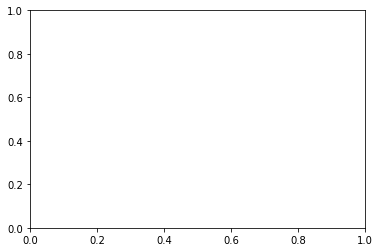

In [94]:
# Import `pyplot` and `numpy`
import matplotlib.pyplot as plt
import numpy as np

# Isolate feature importances 
importance = rfc.feature_importances_

# Sort the feature importances 
sorted_importances = np.argsort(importance)

# Insert padding
padding = np.arange(len(names)-1) + 0.5

# Plot the data
plt.barh(padding, importance[sorted_importances], align='center')

# Customize the plot
plt.yticks(padding, names[sorted_importances])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")

# Show the plot
plt.show()


## apriori
https://github.com/chris1610/pbpython/blob/master/notebooks/Market_Basket_Intro.ipynb

pip install mlxtend==0.15.0.0

https://pypi.org/project/mlxtend/0.15.0.0/

basket is cluster , terms are one hot encoded


In [137]:
test['list_terms'] =test['Terms'].str.split()


In [62]:
test.to_excel('test_clustered_1.xlsx')


In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


    
from sklearn.preprocessing import MultiLabelBinarizer

In [138]:
# Create MultiLabelBinarizer object
one_hot = MultiLabelBinarizer()

In [139]:
table = pd.DataFrame(one_hot.fit_transform(test.list_terms), 
                     columns=one_hot.classes_)
print(table.shape)

(61556, 17355)


In [140]:
table['cluster']=test.Cluster
table =table.set_index('cluster')
print(table.shape)

(61556, 17354)


In [166]:
sample = table.sample(frac=0.01).reset_index(drop=True)

In [181]:
#need to groupby cluster so no. of rows = no. of clusters

basket = (sample.groupby(sample.index)
         .sum().unstack().reset_index().fillna(0)
         .set_index(sample.index))



ValueError: Length mismatch: Expected axis has 10690064 elements, new values have 616 elements

In [ ]:
print(sample.shape,basket.shape)
basket.head()

In [149]:
table.head()

,aaamoveobj,aaboseif,aaboytes,aabramson,aabrenica,aacc,aaccount,aacn,aadekile,aadriani,...,zsteric,zupar,zweingarten,zwoldesilasse,zyang,zzaheer,zzdefault,zzlallgower,zzz,¬disablement
cluster,,,,,,,,,,,,,,,,,,,,,
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#earlier was doing assignment groups as one hot encoded, but it did not work, 

#basket_sets.head()

,DH-ALMsupport,DH-AS400_Support,DH-BNI_Informatics,DH-ClinApps_CPOE,DH-ClinApps_Cardiology_and_Diagnostic_Solutions,DH-ClinApps_Charges,DH-ClinApps_Core,DH-ClinApps_Custom_MPage,DH-ClinApps_Custom_Program,DH-ClinApps_Environment,...,DHE-ServiceMatters_Data_Management,DHE-ServiceNow_System_Admin,DHE-SharePoint_SysAdmin,DHE-Software_Asset_Mgmt,DHE-TECHOPS_ERP_SysAdmin,DHE-TECHOPS_Web_SysAdmin,DHE-TS-DBA,DHE-TS-MIDRANGE-MEDITECH,DHE-TS-Unix,DHE-UC_Contact_Center
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,1,0,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# Build up the frequent items
%time frequent_itemsets = apriori(table, min_support=0.07, use_colnames=True)

frequent_itemsets.head()

Wall time: 1min 18s


,support,itemsets
0,0.108811,(account)
1,0.071642,(dev)
2,0.077474,(device)
3,0.181282,(login)
4,0.087595,(need)


In [143]:
# Create the rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(account),(user),0.108811,0.253005,0.070001,0.643326,2.542738,0.042471,2.094336
1,(user),(account),0.253005,0.108811,0.070001,0.276679,2.542738,0.042471,1.232079
2,(login),(unable),0.181282,0.306989,0.162844,0.898288,2.926128,0.107192,6.813491
3,(unable),(login),0.306989,0.181282,0.162844,0.530455,2.926128,0.107192,1.743639
4,(login),(user),0.181282,0.253005,0.107528,0.593154,2.344430,0.061663,1.836060


In [146]:
rules[ (rules['lift'] >= 1.5) &
       (rules['confidence'] >= 0.5) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(account),(user),0.108811,0.253005,0.070001,0.643326,2.542738,0.042471,2.094336
2,(login),(unable),0.181282,0.306989,0.162844,0.898288,2.926128,0.107192,6.813491
3,(unable),(login),0.306989,0.181282,0.162844,0.530455,2.926128,0.107192,1.743639
4,(login),(user),0.181282,0.253005,0.107528,0.593154,2.344430,0.061663,1.836060
7,(user),(unable),0.253005,0.306989,0.132578,0.524014,1.706950,0.054909,1.455950
8,"(login, unable)",(user),0.162844,0.253005,0.095831,0.588488,2.325988,0.054631,1.815242
9,"(login, user)",(unable),0.107528,0.306989,0.095831,0.891222,2.903110,0.062822,6.370891
10,"(user, unable)",(login),0.132578,0.181282,0.095831,0.722828,3.987311,0.071797,2.953827
11,(login),"(user, unable)",0.181282,0.132578,0.095831,0.528632,3.987311,0.071797,1.840220


In [147]:
test.shape

(61556, 22)

In [148]:
test['tempdate'] = pd.to_datetime(df.Created)
test['date'] = test.tempdate.dt.date
test['day']  = test.tempdate.dt.strftime('%A')

In [152]:
table1=table.copy()

In [153]:
table1['date']=test.date
table1 = table1.set_index('date')

In [156]:
table1.head()

,aaamoveobj,aaboseif,aaboytes,aabramson,aabrenica,aacc,aaccount,aacn,aadekile,aadriani,...,zsteric,zupar,zweingarten,zwoldesilasse,zyang,zzaheer,zzdefault,zzlallgower,zzz,¬disablement
date,,,,,,,,,,,,,,,,,,,,,
2018-10-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-10-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-10-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-10-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-10-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
table1.date[:1]

AttributeError: 'DataFrame' object has no attribute 'date'

In [164]:
# Build up the frequent items and rules on table1(date indexed)
%time frequent_itemsets1 = apriori(table1, min_support=0.07, use_colnames=True)
#frequent_itemsets.head()

#rules1 = association_rules(frequent_itemsets1, metric="lift", min_threshold=1)
#rules.head()

MemoryError: 

In [ ]:
rules1[ (rules1['lift'] >= 1.5) &
       (rules1['confidence'] >= 0.5) ]